In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from math import sin, cos, sqrt, atan2, radians
import random
from tqdm import tqdm
import multiprocessing
from multiprocessing import Pool
import glob
import sys
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)
from utils.gsvload import GSVSummary
import concurrent.futures

# Goal:
1. Check downloaded data
2. Create the updated {city}_meta.csv file for each city 
3. the {city}_meta.csv should only include the downloade gsv and selected data in gsv_pano_label.csv
4. this meta file is used for segmentation and city never was project. Remaining downloaded data will stay in the gsv_path.csv file
5. Check total number available data per year per city

In [2]:
META_FILE = "{citylower}_meta.csv"
city = "New York"
city_abbr = city.lower().replace(" ", "_")
meta_file= META_FILE.format(citylower = city_abbr.replace("_", ""))
citysummary = GSVSummary(city)
GSV_META_FOLDER = citysummary.metafolder

meta_df = pd.read_csv(os.path.join(citysummary.metafolder, meta_file), nrows= 1)

In [2]:
meta = {
    "path":"path to the gsv",
    "panoid":"unique identifier",
    "angle":"image angle",
    "size":"image size",
    "lat":"latitude",
    "lon":"longitude",
    "year":"year taken",
    "month":"month",
    "id":"image id",
    "dist_hav":"distance from the city center", 
    "h3_res8":"h3 level 8",
    "h3_res9":"h3 level 9"
}

# 1. Check all data availability

In [9]:
ROOT = "/lustre1/g/geog_pyloo"
serviceaccount = "../../google_drive_personal.json"
import gspread

# from oauth2client.service_account import ServiceAccountCredentials
gc = gspread.service_account(filename=serviceaccount)


def read_url(url, SHEET_NAME):
    SHEET_ID = url.split("/")[5]
    spreadsheet = gc.open_by_key(SHEET_ID)
    worksheet = spreadsheet.worksheet(SHEET_NAME)
    rows = worksheet.get_all_records()
    df_spread = pd.DataFrame(rows)
    return df_spread, worksheet


url = "https://docs.google.com/spreadsheets/d/1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw/edit?usp=sharing"
SHEETNAME = "select_city_classifier"
city_meta, other_worksheet = read_url(url, SHEETNAME)
city_meta = city_meta[city_meta['City']!=''].reset_index(drop = True)
city_meta.head()


,City,Country,Continent,State/Province,center_lat,center_lng,label,num_panoid,GSV Downloaded,Drink & Drive Imprison,Annual Raindrop,left,bottom,right,top,urban_pop,pop source,country_clean,county_ls
0,Buenos Aires,Argentina,South America,Buenos Aires,-34.599589,-58.380564,18,606938,2365132,,,-58.531449,-34.705181,-58.335352,-34.526573,3120612,2022,Argentina,[]
1,Sydney,Australia,Australia,New South Wales,-33.870453,151.208755,112,3411953,1413083,,,150.264995,-34.171875,151.341577,-33.378928,5312000,2019,Australia,[]
2,Vienna,Austria,Europe,Vienna,48.208166,16.371864,122,1166126,319435,,,16.182084,48.118545,16.577249,48.320919,1897000,2019,Austria,[]
3,Saidpur,Bangladesh,Asia,Rangpur Division,25.778031,88.897626,102,4442,12721,,,88.851607,25.740739,88.995211,25.863039,24338,2011,Bangladesh,[]
4,Rajshahi,Bangladesh,Asia,Rajshahi,24.374650,88.600367,95,240371,186022,,,88.017099,23.812853,89.754481,25.270728,984000,2024,Bangladesh,[]


In [6]:
def get_path(subfolder):
    files = glob.glob(os.path.join(subfolder, "*/*/*.jpg"))
    return files


def get_file_size(file):
    try:
        return file, os.path.getsize(file)
    except OSError as e:
        print(f"Error: {e}")
        return file, None


class GSVnew(GSVSummary):
    def __init__(self, city):
        super().__init__(city)

    def get_gsv_file_size(self, gsv_meta_df):
        gsvpath = gsv_meta_df.copy()
        files = gsvpath["path"].values
        # Store file sizes in a dictionary
        file_sizes = {}
        with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
            # The map method helps maintain the order of results
            results = executor.map(get_file_size, files)

            for file, size in results:
                if size is not None:
                    file_sizes[file] = size
                else:
                    file_sizes[file] = 0  # the file is removed

        gsvpath["size"] = gsvpath["path"].apply(lambda x: file_sizes[x])
        # gsvpath.to_csv(os.path.join(self.metafolder, "gsv_path.csv"), index=False)
        return gsvpath

## 2.Check all downloaded GSV
1. Count number of GSV downloaded
2. Generate the gsv_path.csv file for all downloaded gsv

In [4]:
import datetime

today = datetime.datetime.today().strftime("%Y-%m-%d")
gsv_path_file = "gsv_path.csv"

In [17]:
# current being transfered, can summarize later
city_to_transfer = ['jakarta', 
                    'lima', # fully transfered
                    'metromanila', # fully transfered
                    'nagoya',# fully transfered
                    'riodejaneiro',# fully transfered
                    'milan', # 
                    'bangkok',
                    'toronto',
                    'kualalumpur'
                   ]
new_cities = city_meta[city_meta["GSV Downloaded"]==""]["City"].unique()

In [11]:
# This function checks whether there are more gsv downloaded but not included in the gsv_path file
noimage = []
for city in tqdm(new_cities):
    print(city)
    citysummary = GSVnew(city)
    gsvpath = citysummary.load_finshed_gsv()
    # gsvpath.to_csv(os.path.join(citysummary.metafolder, "gsv_path_revise.csv"), index = False)
    # if gsvpath.shape[0]>0:
#         # load previous gsv path
#         try:
#             gsvpath_original = pd.read_csv(os.path.join(citysummary.metafolder, "gsv_path.csv"))
#             print(gsvpath_original.shape[0], ": original")
#             remain = gsvpath[
#                 gsvpath["panoid"].isin(gsvpath_original["panoid"]) == False
#             ].reset_index(drop=True)
#             if remain.shape[0] > 0:
#                 gsvpath_update = citysummary.get_gsv_file_size(remain)

#                 gsvpath_new = pd.concat([gsvpath_original, gsvpath_update], axis=0)
#                 print(gsvpath_new.shape[0], ": original+new")
#                 gsvpath_new.to_csv(
#                     os.path.join(citysummary.metafolder, "gsv_path.csv"), index=False
#                 )
#             else:
#                 print("no new gsv")
#             # os.remove(os.path.join(citysummary.metafolder, gsv_path_file))
#         except:
#             print("no path file exists")
#         gsvpath_update = citysummary.get_gsv_file_size(remain) # then it will include the file size
#         gsvpath_update.to_csv(
#                 os.path.join(citysummary.metafolder, "gsv_path.csv"), index=False
#             )
#     else:
#         print(city, " has no images downloaded")
#         noimage.append(city)

    gsvpath['panoid'] = gsvpath['path'].apply(lambda x: x.split("/"))
    gsvpath.to_csv(
                    os.path.join(citysummary.metafolder, "gsv_path.csv"), index=False
                )


  0%|          | 0/2 [00:00<?, ?it/s]

Toronto



 50%|█████     | 1/2 [00:18<00:18, 18.07s/it]

Kualalumpur



100%|██████████| 2/2 [00:34<00:00, 17.33s/it]


In [ ]:
gsvpath['panoid'] = gsvpath['path'].apply(lambda x: x.split("/"))
gsvpath.to_csv(
                os.path.join(citysummary.metafolder, "gsv_path.csv"), index=False
            )
                                          

In [8]:
road_result = []
pano_result = []
gsv_result = []

for city in tqdm(new_cities):
    result = GSVnew(city)
    try:
        road_result.append(result.check_road())
    except:
        road_result.append(0)
    try:
        pano_result.append(result.check_pano()[1])
    except:
        pano_result.append(0)
    try:
        gsvdf = result.load_gsv_path()
        n = gsvdf.shape[0]
        gsv_result.append(n)
    except:
        gsv_result.append(0)

100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


In [9]:
inspectdf = pd.DataFrame(
    {
        "city": new_cities,
        "num_panoid": pano_result,
        "road": road_result,
        "GSV Downloaded": gsv_result,
    }
)
inspectdf

,city,num_panoid,road,GSV Downloaded
0,Vienna,1166126,1,319435


In [10]:

city_meta = city_meta.set_index('City')
for city in inspectdf.city.unique():
    temp = inspectdf[inspectdf['city']==city].reset_index(drop = True)
    city_meta.at[city, 'num_panoid'] = temp['num_panoid'].values[0]
    city_meta.at[city,  'road'] = temp['road'].values[0]
    city_meta.at[city,  'GSV Downloaded'] = temp['GSV Downloaded'].values[0]

In [11]:
city_meta = city_meta.reset_index()
city_meta = city_meta.astype(str)
city_meta = city_meta[city_meta['City']!='nan'].reset_index(drop = True)

In [12]:
# write to google sheet
other_worksheet.update(
    [city_meta.columns.values.tolist()] + city_meta.values.tolist()
)

{'spreadsheetId': '1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw',
 'updatedRange': 'select_city!A1:M160',
 'updatedRows': 160,
 'updatedColumns': 13,
 'updatedCells': 2080}

# Check Chicago data distribution

In [44]:
city = 'Hong Kong'
cityabbrlower = city.lower().replace(" ", "")
citysummary = GSVnew(city)
df = pd.read_csv(os.path.join(citysummary.metafolder, "gsv_path.csv"))

In [11]:
df_pano = pd.read_csv(os.path.join(citysummary.metafolder, "gsv_pano.csv"))
df_pano.shape

(8780030, 6)

In [24]:
# select all panos within the city of chicago first
# load chicago boundary
import geopandas as gpd
boundary_root = "/lustre1/g/geog_pyloo/05_timemachine/_raw/r_boundary_osm"
chicago_boundary = gpd.read_file(os.path.join(boundary_root, f"{cityabbrlower}.geojson"))
chicago_boundary

,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name,geometry
0,42.02304,41.644531,-87.524081,-87.940088,324747941,relation,122604,41.875562,-87.624421,boundary,administrative,16,0.75153,city,Chicago,"Chicago, Cook County, Illinois, United States","POLYGON ((-87.94009 42.00080, -87.94003 41.998..."


In [32]:
# df_pano = gpd.GeoDataFrame(df_pano, geometry=gpd.points_from_xy(df_pano.lon, df_pano.lat))
# df_pano.crs = "EPSG:4326"
df_pano_within = gpd.sjoin(df_pano, chicago_boundary[['geometry']])
df_pano_within.shape

(2549263, 8)

In [43]:
df.head()

,path,panoid,size,angle
0,/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...,l_9OQZv7XQRXgO9rjnPa9w,13353,0
1,/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...,vTIkHjzUa30fO-PgTrzHzw,45386,270
2,/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...,jcPNvZzJYlzNmqqe96W1IQ,49434,180
3,/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...,r93gVzbIS5kQdKUSkVB6UA,27795,90
4,/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...,RiB5NFYF4Z2YXGzRtdYZ1A,43184,180


In [37]:
df_pano_within['year'].unique()

array([2021., 2019., 2018., 2015., 2014., 2012., 2011., 2007., 2022.,
       2017., 2009., 2008., 2016., 2013., 2023., 2010., 2020.])

In [40]:
todownload = df_pano_within[df_pano_within['year']>=2011][df_pano.columns].reset_index(drop = True)
# save the data into 4 parts
n = 4
l = len(todownload)
step = l//n
for i in range(n):
    if i<n-1:
        temp = todownload.iloc[i*step:(i+1)*step]
    else:
        temp = todownload.iloc[i*step:]
    temp.to_csv(os.path.join(citysummary.metafolder, f"gsv_pano_within_{i}.csv"), index = False)

In [33]:
df_pano_within[df_pano_within['year']>=2011][df_pano.columns].to_csv(os.path.join(citysummary.metafolder, "gsv_pano_within.csv"), index = False)

In [42]:
import gc
gc.collect()

0

In [34]:
df_pano_within.shape

(2549263, 8)

<Axes: >

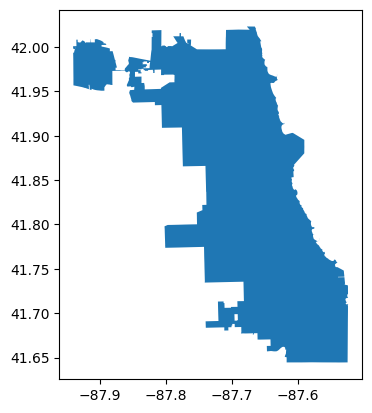

In [25]:
chicago_boundary.plot()

In [20]:
df.shape

(2997840, 4)

# Create final pano meta file for analysis


In [14]:
# cityabbr = city.lower().replace(" ", "")
META_FILE = '{cityabbr}_meta.csv'
META_FOLDER = "gsvmeta"
GSVROOT = "/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/"
# city_meta['GSV Downloaded'] = city_meta['GSV Downloaded'].astype(int)
# cityls = city_meta[city_meta['GSV Downloaded']>0]['City'].unique()


In [14]:
for city in tqdm(['Vienna']): 
    # Step 0: check whether the meta data already exists
    cityabbr = city.lower().replace(" ", "")
    metafiles = os.listdir(os.path.join(GSVROOT, cityabbr, META_FOLDER))
    meta_file = META_FILE.format(cityabbr = cityabbr)
    
        # Step 1: check remaining data to add to the path
    citysummary = GSVSummary(city)
    gsvpath = pd.read_csv(os.path.join(citysummary.metafolder, "gsv_path.csv"))
    print(gsvpath.head(1))
    path_sample = gsvpath['path'].values[0]
    if "/data/" in path_sample:
        print(path_sample)
        print("need to correct the path")
        gsvpath['path'] = gsvpath['path'].apply(lambda x: x.replace("./data/", "/lustre1/g/geog_pyloo/05_timemachine/GSV/"))
        gsvpath.to_csv(os.path.join(citysummary.metafolder, "gsv_path.csv"), index = False)

    else:
        print("Path is already correct")
        print(gsvpath.shape[0], ": original")
    
    if meta_file in metafiles:
        print(f"CITY {city} meta file already exists")

    else:
        print("Meta file missing, now processing: ", city)
        
        # Step 2: merge the meta file and save file
        metadf_update = citysummary.merge_meta(sel = True)
        metadf_update.drop("geometry", axis = 1).to_csv(os.path.join(GSVROOT, cityabbr, META_FOLDER, meta_file), index = False)
        print("final saved file number of rows: ", metadf_update.shape[0])
        import gc
        gc.collect()


  0%|          | 0/1 [00:00<?, ?it/s]

                                                path                  panoid
0  /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...  gQwGknUmHhpaulRLzw_1AQ
Path is already correct
319435 : original
Meta file missing, now processing:  Vienna


100%|██████████| 1/1 [00:06<00:00,  6.79s/it]

final saved file number of rows:  347836


In [15]:
metadf_update.drop("geometry", axis = 1).drop_duplicates("path").to_csv(os.path.join(GSVROOT, cityabbr, META_FOLDER, meta_file), index = False)

In [87]:
# clean all the meta file to drop geometry and drop duplicates
for city in tqdm(cityls):
    cityabbr = city.lower().replace(" ", "")
    metafiles = os.listdir(os.path.join(GSVROOT, cityabbr, META_FOLDER))
    meta_file = META_FILE.format(cityabbr = cityabbr)
    
        # Step 1: check remaining data to add to the path
    citysummary = GSVSummary(city)
    metadf = pd.read_csv(os.path.join(GSVROOT, cityabbr, META_FOLDER, meta_file))
    if 'geometry' in metadf.columns:
        metadf.drop('geometry', axis = 1).drop_duplicates("path").to_csv(os.path.join(GSVROOT, cityabbr, META_FOLDER, meta_file), index = False)
    else:
        print("data fixed, continue")
        continue

  1%|          | 1/126 [00:02<04:37,  2.22s/it]

data fixed, continue


  2%|▏         | 2/126 [00:04<04:57,  2.40s/it]

data fixed, continue


  2%|▏         | 3/126 [00:05<03:09,  1.54s/it]

data fixed, continue


  3%|▎         | 4/126 [00:05<02:17,  1.13s/it]

data fixed, continue


  4%|▍         | 5/126 [00:10<04:48,  2.38s/it]

data fixed, continue


  5%|▍         | 6/126 [00:11<03:34,  1.79s/it]

data fixed, continue


  6%|▌         | 7/126 [00:11<02:33,  1.29s/it]

data fixed, continue


  6%|▋         | 8/126 [00:14<03:54,  1.99s/it]

data fixed, continue


  7%|▋         | 9/126 [00:15<03:11,  1.64s/it]

data fixed, continue


  8%|▊         | 10/126 [00:15<02:18,  1.20s/it]

data fixed, continue


  9%|▊         | 11/126 [00:16<01:49,  1.05it/s]

data fixed, continue


 10%|▉         | 12/126 [00:16<01:32,  1.24it/s]

data fixed, continue


 10%|█         | 13/126 [00:17<01:21,  1.39it/s]

data fixed, continue


 11%|█         | 14/126 [00:17<01:11,  1.56it/s]

data fixed, continue


 12%|█▏        | 15/126 [00:18<01:06,  1.66it/s]

data fixed, continue


 13%|█▎        | 16/126 [00:18<01:04,  1.72it/s]

data fixed, continue


 13%|█▎        | 17/126 [00:19<01:02,  1.74it/s]

data fixed, continue


 14%|█▍        | 18/126 [00:24<03:24,  1.89s/it]

data fixed, continue


 15%|█▌        | 19/126 [00:24<02:39,  1.49s/it]

data fixed, continue


 16%|█▌        | 20/126 [00:25<02:06,  1.20s/it]

data fixed, continue


 17%|█▋        | 21/126 [00:25<01:48,  1.03s/it]

data fixed, continue


 17%|█▋        | 22/126 [00:29<03:19,  1.92s/it]

data fixed, continue


 18%|█▊        | 23/126 [00:34<04:40,  2.73s/it]

data fixed, continue


 19%|█▉        | 24/126 [00:35<03:39,  2.15s/it]

data fixed, continue


 20%|█▉        | 25/126 [00:36<02:57,  1.76s/it]

data fixed, continue


 21%|██        | 26/126 [00:40<04:18,  2.58s/it]

data fixed, continue


 21%|██▏       | 27/126 [00:41<03:19,  2.01s/it]

data fixed, continue


 22%|██▏       | 28/126 [00:42<02:55,  1.79s/it]

data fixed, continue


 23%|██▎       | 29/126 [00:44<02:52,  1.78s/it]

data fixed, continue


 24%|██▍       | 30/126 [00:45<02:21,  1.47s/it]

data fixed, continue


 25%|██▍       | 31/126 [00:45<01:58,  1.25s/it]

data fixed, continue


 25%|██▌       | 32/126 [00:46<01:43,  1.10s/it]

data fixed, continue


 26%|██▌       | 33/126 [00:47<01:32,  1.01it/s]

data fixed, continue


 27%|██▋       | 34/126 [00:48<01:26,  1.06it/s]

data fixed, continue


 28%|██▊       | 35/126 [00:53<03:16,  2.16s/it]

data fixed, continue


 29%|██▊       | 36/126 [00:54<02:45,  1.83s/it]

data fixed, continue


 29%|██▉       | 37/126 [02:08<35:04, 23.65s/it]

data fixed, continue


 30%|███       | 38/126 [02:13<26:23, 17.99s/it]

data fixed, continue


 31%|███       | 39/126 [02:14<18:51, 13.01s/it]

data fixed, continue


 32%|███▏      | 40/126 [02:18<14:35, 10.18s/it]

data fixed, continue


 33%|███▎      | 41/126 [02:19<10:38,  7.51s/it]

data fixed, continue


 33%|███▎      | 42/126 [02:21<08:01,  5.73s/it]

data fixed, continue


 34%|███▍      | 43/126 [02:22<06:06,  4.41s/it]

data fixed, continue


 35%|███▍      | 44/126 [02:24<04:46,  3.49s/it]

data fixed, continue


 36%|███▌      | 45/126 [02:25<03:53,  2.88s/it]

data fixed, continue


 37%|███▋      | 46/126 [02:26<03:15,  2.44s/it]

data fixed, continue


 37%|███▋      | 47/126 [02:27<02:38,  2.00s/it]

data fixed, continue


 38%|███▊      | 48/126 [02:38<06:05,  4.68s/it]

data fixed, continue


 39%|███▉      | 49/126 [02:39<04:20,  3.38s/it]

data fixed, continue


 40%|███▉      | 50/126 [02:40<03:32,  2.79s/it]

data fixed, continue


 40%|████      | 51/126 [02:41<02:50,  2.28s/it]

data fixed, continue


 41%|████▏     | 52/126 [02:43<02:34,  2.09s/it]

data fixed, continue


 42%|████▏     | 53/126 [02:50<04:26,  3.65s/it]

data fixed, continue


 43%|████▎     | 54/126 [02:51<03:32,  2.95s/it]

data fixed, continue


 44%|████▎     | 55/126 [02:52<02:38,  2.23s/it]

data fixed, continue


 44%|████▍     | 56/126 [02:55<02:56,  2.52s/it]

data fixed, continue


 45%|████▌     | 57/126 [02:56<02:20,  2.04s/it]

data fixed, continue


 46%|████▌     | 58/126 [02:57<01:57,  1.73s/it]

data fixed, continue


 47%|████▋     | 59/126 [02:57<01:27,  1.30s/it]

data fixed, continue


 48%|████▊     | 60/126 [02:58<01:18,  1.19s/it]

data fixed, continue


 48%|████▊     | 61/126 [03:06<03:26,  3.18s/it]

data fixed, continue


 49%|████▉     | 62/126 [03:07<02:40,  2.50s/it]

data fixed, continue


 50%|█████     | 63/126 [03:09<02:20,  2.23s/it]

data fixed, continue


 51%|█████     | 64/126 [03:11<02:17,  2.21s/it]

data fixed, continue


 52%|█████▏    | 65/126 [03:11<01:41,  1.66s/it]

data fixed, continue


 52%|█████▏    | 66/126 [03:12<01:26,  1.44s/it]

data fixed, continue


 53%|█████▎    | 67/126 [03:14<01:25,  1.45s/it]

data fixed, continue


 54%|█████▍    | 68/126 [03:15<01:15,  1.30s/it]

data fixed, continue


 55%|█████▍    | 69/126 [03:16<01:11,  1.26s/it]

data fixed, continue


 56%|█████▌    | 70/126 [03:25<03:16,  3.51s/it]

data fixed, continue


 56%|█████▋    | 71/126 [03:25<02:20,  2.56s/it]

data fixed, continue


 57%|█████▋    | 72/126 [03:26<01:57,  2.18s/it]

data fixed, continue


 58%|█████▊    | 73/126 [03:26<01:24,  1.60s/it]

data fixed, continue


 59%|█████▊    | 74/126 [03:37<03:40,  4.23s/it]

data fixed, continue


 60%|█████▉    | 75/126 [03:38<02:42,  3.18s/it]

data fixed, continue


 60%|██████    | 76/126 [03:39<02:06,  2.52s/it]

data fixed, continue


 61%|██████    | 77/126 [03:40<01:41,  2.08s/it]

data fixed, continue


 62%|██████▏   | 78/126 [03:40<01:15,  1.58s/it]

data fixed, continue


 63%|██████▎   | 79/126 [03:41<01:09,  1.48s/it]

data fixed, continue


 63%|██████▎   | 80/126 [03:42<01:03,  1.38s/it]

data fixed, continue


 64%|██████▍   | 81/126 [03:43<00:46,  1.04s/it]

data fixed, continue


 65%|██████▌   | 82/126 [03:44<00:46,  1.05s/it]

data fixed, continue


 66%|██████▌   | 83/126 [03:45<00:46,  1.09s/it]

data fixed, continue


 67%|██████▋   | 84/126 [03:46<00:46,  1.12s/it]

data fixed, continue


 67%|██████▋   | 85/126 [03:47<00:45,  1.12s/it]

data fixed, continue


 68%|██████▊   | 86/126 [03:49<00:56,  1.42s/it]

data fixed, continue


 69%|██████▉   | 87/126 [03:50<00:48,  1.24s/it]

data fixed, continue


 70%|██████▉   | 88/126 [03:50<00:35,  1.07it/s]

data fixed, continue


 71%|███████   | 89/126 [03:51<00:26,  1.39it/s]

data fixed, continue


 71%|███████▏  | 90/126 [03:51<00:20,  1.75it/s]

data fixed, continue


 72%|███████▏  | 91/126 [03:51<00:19,  1.76it/s]

data fixed, continue


 73%|███████▎  | 92/126 [03:52<00:24,  1.38it/s]

data fixed, continue


 74%|███████▍  | 93/126 [03:53<00:20,  1.61it/s]

data fixed, continue


 75%|███████▍  | 94/126 [03:53<00:17,  1.78it/s]

data fixed, continue


 75%|███████▌  | 95/126 [03:54<00:15,  1.99it/s]

data fixed, continue


 76%|███████▌  | 96/126 [03:55<00:21,  1.43it/s]

data fixed, continue


 77%|███████▋  | 97/126 [03:55<00:16,  1.75it/s]

data fixed, continue


 78%|███████▊  | 98/126 [03:57<00:26,  1.08it/s]

data fixed, continue


 79%|███████▊  | 99/126 [03:58<00:30,  1.11s/it]

data fixed, continue


 79%|███████▉  | 100/126 [03:59<00:22,  1.15it/s]

data fixed, continue


 80%|████████  | 101/126 [04:00<00:27,  1.08s/it]

data fixed, continue


 81%|████████  | 102/126 [04:02<00:29,  1.25s/it]

data fixed, continue


 82%|████████▏ | 103/126 [04:04<00:33,  1.45s/it]

data fixed, continue


 83%|████████▎ | 104/126 [04:06<00:33,  1.54s/it]

data fixed, continue


 83%|████████▎ | 105/126 [04:07<00:33,  1.57s/it]

data fixed, continue


 84%|████████▍ | 106/126 [04:09<00:32,  1.63s/it]

data fixed, continue


 85%|████████▍ | 107/126 [04:12<00:36,  1.91s/it]

data fixed, continue


 86%|████████▌ | 108/126 [04:13<00:33,  1.84s/it]

data fixed, continue


 87%|████████▋ | 109/126 [04:16<00:33,  1.98s/it]

data fixed, continue


 87%|████████▋ | 110/126 [04:16<00:23,  1.50s/it]

data fixed, continue


 88%|████████▊ | 111/126 [04:17<00:21,  1.42s/it]

data fixed, continue


 89%|████████▉ | 112/126 [04:19<00:22,  1.61s/it]

data fixed, continue


 90%|████████▉ | 113/126 [04:22<00:24,  1.89s/it]

data fixed, continue


 90%|█████████ | 114/126 [04:24<00:24,  2.01s/it]

data fixed, continue


 91%|█████████▏| 115/126 [04:26<00:22,  2.04s/it]

data fixed, continue


 92%|█████████▏| 116/126 [04:27<00:15,  1.58s/it]

data fixed, continue


 93%|█████████▎| 117/126 [04:27<00:10,  1.19s/it]

data fixed, continue


 94%|█████████▎| 118/126 [04:29<00:11,  1.49s/it]

data fixed, continue


 94%|█████████▍| 119/126 [04:31<00:10,  1.54s/it]

data fixed, continue


 96%|█████████▌| 121/126 [04:31<00:04,  1.11it/s]

data fixed, continue
data fixed, continue


 97%|█████████▋| 122/126 [04:32<00:02,  1.36it/s]

data fixed, continue


 98%|█████████▊| 123/126 [04:34<00:03,  1.23s/it]

data fixed, continue


 98%|█████████▊| 124/126 [04:38<00:03,  1.99s/it]

data fixed, continue


 99%|█████████▉| 125/126 [04:38<00:01,  1.52s/it]

data fixed, continue


100%|██████████| 126/126 [04:41<00:00,  2.23s/it]

data fixed, continue


# Check all data year distribution

In [16]:
# ROOTFOLDER = "/lustre1/g/geog_pyloo/05_timemachine"
# PANO_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/gsv_path.csv"
# META_FOLDER = "gsvmeta"
# GSVROOT = "/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/"

year_summary = []
for city in tqdm(city_meta["City"].unique()[16:]):
    try:
        cityabbr = city.lower().replace(" ", "")
        df = pd.read_csv(PANO_PATH.format(ROOTFOLDER = ROOTFOLDER, cityabbr = cityabbr))
        df["panoid"] = df["path"].apply(lambda x: x.split("/")[-1][:22])
        
        df_pano = pd.read_csv(os.path.join(GSVROOT, cityabbr, META_FOLDER, "gsv_pano.csv"))
        df_merge = df.merge(df_pano, on = "panoid")
        
        df_summary = df_merge.groupby("year")['panoid'].nunique().reset_index().rename(columns = {0:"count"})
        df_summary["city"] = city
        year_summary.append(df_summary)
    except:
        print(city, " has no data")
year_summary = pd.concat(year_summary).reset_index(drop = True)
# year_summary.to_csv("annual_summary.csv")



100%|██████████| 111/111 [08:32<00:00,  4.62s/it]


In [20]:
year_summary = year_summary.drop_duplicates()

In [24]:
year_summary.to_csv("annual_summary.csv", index = False)

In [2]:
year_summary = pd.read_csv("annual_summary.csv")
year_summary["year"] = year_summary["year"].astype(int)
to_update = year_summary.pivot(columns = ["year"], index = "city", values = "panoid").reset_index().fillna(0)
to_update

year,city,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Accra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37503.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Amsterdam,0.0,29620.0,119571.0,53622.0,7322.0,0.0,1.0,58608.0,70424.0,85169.0,58077.0,57593.0,68362.0,88354.0,115590.0,141438.0,75710.0,0.0
2,Antwerp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4442.0,3896.0,5351.0,8593.0,5139.0,3542.0,6278.0,0.0
3,Astrakhan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1161.0,1993.0,2068.0,652.0,2769.0,0.0,11851.0,0.0,0.0,0.0
4,Athens,0.0,0.0,13627.0,92.0,91442.0,16642.0,0.0,75533.0,8.0,0.0,0.0,0.0,15846.0,0.0,10247.0,80589.0,17942.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,Vijayawada,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3011.0,0.0,0.0
123,Warsaw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,16804.0,19297.0,26109.0,5834.0,11670.0,21848.0,0.0,0.0
124,Wellington,0.0,14650.0,15425.0,450.0,5.0,66.0,14190.0,896.0,19339.0,0.0,6194.0,3512.0,16411.0,4043.0,3504.0,12140.0,281.0,0.0
125,Yamaguchi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4916.0,0.0,6370.0,15764.0,12912.0,4449.0,13601.0,23589.0,81054.0,0.0


In [8]:
url = "https://docs.google.com/spreadsheets/d/1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw/edit?usp=sharing"
SHEETNAME = "data distribution by year"
_, other_worksheet = read_url(url, SHEETNAME)
# city_meta = city_meta[city_meta['City']!=''].reset_index(drop = True)
# city_meta.head()

In [23]:
other_worksheet.update(
    [to_update.columns.values.tolist()] + to_update.values.tolist()
)

{'spreadsheetId': '1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw',
 'updatedRange': "'data distribution by year'!A1:S128",
 'updatedRows': 128,
 'updatedColumns': 19,
 'updatedCells': 2432}

In [3]:
to_update.columns

Index(['city',   2007,   2008,   2009,   2010,   2011,   2012,   2013,   2014,
         2015,   2016,   2017,   2018,   2019,   2020,   2021,   2022,   2023,
         2024],
      dtype='object', name='year')

In [4]:
# check data before 2014
year_group = ['<2014','2014-2015','2016-2017','2018-2019', '2020-2021','2022-2023']
column_map = {
    "<2014":[2007,   2008,   2009,   2010,   2011,   2012,   2013,],
    "2014-2015":[2014, 2015],
    "2016-2017":[2016, 2017],
    "2018-2019":[2018, 2019],
    "2020-2021":[2020, 2021],
    "2022-2023":[2022, 2023]
    
}
to_update_simp = to_update.copy()

for key, value in column_map.items():
    to_update_simp[key] = to_update_simp[value].sum(axis = 1)
to_update_simp = to_update_simp[['city'] +year_group ]


In [25]:
# check data before 2014
year_group = ['<2014','2015-2018', '2020-2023']
to_update['<2014'] = to_update[[2010, 2011, 2012, 2013]].sum(axis = 1)
to_update['2015-2018'] = to_update[[2015, 2016, 2017, 2018]].sum(axis = 1)
to_update['2020-2023'] = to_update[[2020, 2021, 2022, 2023]].sum(axis = 1)
to_update_simp = to_update[["city", "<2014", "2015-2018", "2020-2023"]]
to_update_simp

year,city,<2014,2015-2018,2020-2023
0,Accra,0.0,37503.0,0.0
1,Amsterdam,60945.0,271263.0,421092.0
2,Antwerp,0.0,8338.0,23552.0
3,Astrakhan,0.0,5874.0,11851.0
4,Athens,108176.0,8.0,108778.0
...,...,...,...,...
122,Vijayawada,0.0,0.0,3011.0
123,Warsaw,0.0,36175.0,39352.0
124,Wellington,14711.0,29045.0,19968.0
125,Yamaguchi,0.0,27050.0,122693.0


In [11]:
# create a new sheet
url = "https://docs.google.com/spreadsheets/d/1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw/edit?usp=sharing"
sheet_name = "data-year group"
spreadsheet = gc.open_by_url(url)
worksheet = spreadsheet.add_worksheet(title = sheet_name, rows = 120, cols = 4)
worksheet.update([to_update_simp.columns.values.tolist()] + to_update_simp.values.tolist())

{'spreadsheetId': '1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw',
 'updatedRange': "'data-year group'!A1:G128",
 'updatedRows': 128,
 'updatedColumns': 7,
 'updatedCells': 896}